In [14]:
%matplotlib inline

# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import importlib
from libs import plots, params, models
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)


<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [15]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [16]:
features_cols  = params.features_cols_tick
label_col      = params.label_col
device         = params.device

df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)

df_features = df_feat[features_cols + ['signal','ask','bid']]
df_features 


,vol_15,ma_5,ma_20,close,hour,bb_width_20,high,low,open,vwap_dev,in_trading,atr_14,r_5,r_1,r_15,signal,ask,bid
2004-01-02 13:09:00,-0.966783,-0.185561,-0.282361,-0.193762,0.493,-0.929333,-0.317313,-0.028125,-0.193147,-0.032030,0,-1.435516,-0.040971,-0.029212,-0.025534,0.016650,0.764807,0.763664
2004-01-02 13:10:00,-0.965007,-0.192087,-0.284115,-0.201725,0.493,-0.921566,-0.324262,-0.037500,-0.201085,-0.036171,0,-1.432540,-0.054390,-0.029213,-0.033477,0.018001,0.764790,0.763647
2004-01-02 13:11:00,-0.963779,-0.200245,-0.286307,-0.209688,0.493,-0.913246,-0.331210,-0.046875,-0.209022,-0.040262,0,-1.429563,-0.067809,-0.029214,-0.041420,0.019462,0.764773,0.763631
2004-01-02 13:12:00,-0.963001,-0.208402,-0.288939,-0.217651,0.493,-0.904541,-0.338159,-0.056250,-0.216960,-0.044296,0,-1.426587,-0.067810,-0.029214,-0.049363,0.021042,0.764757,0.763614
2004-01-02 13:13:00,-0.962622,-0.216560,-0.292008,-0.225614,0.493,-0.895592,-0.345107,-0.065625,-0.224897,-0.048268,0,-1.423611,-0.067812,-0.029215,-0.057307,0.022750,0.764740,0.763597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.507307,0.367023,-0.130453,0.705997,-0.939,0.122381,0.704918,0.500000,0.475806,0.407906,1,2.024482,1.742521,0.837991,1.317936,0.000000,196.962600,196.667400
2025-06-18 20:57:00,0.566581,0.460866,-0.093452,0.478780,-0.939,0.187641,0.836066,0.387097,0.685484,0.263954,1,2.207440,0.887590,-0.939239,1.115397,0.000000,196.822500,196.527500
2025-06-18 20:58:00,0.542508,0.497086,-0.060109,0.470665,-0.939,0.241322,0.508197,0.500000,0.467742,0.254269,1,2.216153,0.341995,-0.033854,0.828890,0.000000,196.817500,196.522500
2025-06-18 20:59:00,0.903328,0.408182,-0.062549,-0.227217,-0.939,0.245429,0.524590,-0.129032,0.475806,-0.173638,1,2.487280,-0.842944,-2.888426,-0.094079,0.000000,196.387200,196.092800


In [20]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_features.index
        .to_series()
        .groupby(df_features.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120, 150]

In [21]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "look_back"    : trial.suggest_categorical("look_back", look_backs),
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.3, 0.45),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.35, 0.5),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.25, 0.4),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    3e-5, 7e-5),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 3e-6),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  3e-4, 7e-4),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.3, 0.7),
    }

    
    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")#
    # Build model
    model = models.DualMemoryLSTM(
        n_feats       = len(features_cols),
        short_units   = params.hparams["SHORT_UNITS"],
        long_units    = params.hparams["LONG_UNITS"],
        dropout_short = hp["DROPOUT_SHORT"],
        dropout_long  = hp["DROPOUT_LONG"],
        att_drop      = hp["ATT_DROPOUT"],
    ).to(device)

    # Build optimizer + schedulers + scaler
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )

    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )

    
    # Build LSTM input tensors (disk-backed memmaps)
    #    Returns five tensors on `device`
    X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
        df             = df_features,
        look_back      = hp["look_back"],
        features_cols  = features_cols,
        label_col      = label_col,
        sess_start     = False # if we want the predictions not to start from sess_start, but from sess_start_pred
    )
    print("Full tensors Shapes:")
    print("  X         =", X.shape,    "(samples, look_back, features)")
    print("  y         =", y.shape,    "(samples,)")
    
    # Split the full sliding‐window dataset (X, y, raw_*) into train, validation,    and test sets by calendar day,    
    (X_tr, y_tr), \
    (X_val, y_val), \
    (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
    samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
        X, y, raw_close, raw_bid, raw_ask, df_features,
        look_back       = hp["look_back"],
        train_prop      = params.train_prop,
        val_prop        = params.val_prop,
        train_batch     = params.hparams['TRAIN_BATCH'],
        sess_start     = False # if we want the predictions not to start from sess_start, but from sess_start_pred

    )
    print("Split tensors Shapes:")
    print("  X_tr =", X_tr.shape)
    print("  X_val =", X_val.shape)
    print("  X_te =", X_te.shape)

    
    #  Build DataLoaders over calendar‐days
    train_loader, val_loader, test_loader = models.split_to_day_datasets(
        # Training split arrays (from chronological_split)
        X_tr, y_tr, day_id_tr,
        # Validation split arrays
        X_val, y_val, day_id_val,
        # Test split arrays + raw prices for post‐tracking
        X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
        # Original minute‐bar DataFrame for weekday mapping
        df=df_features,
        train_batch=params.hparams['TRAIN_BATCH'],
        train_workers=params.hparams['NUM_WORKERS']
    )

    # Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
    n_train_days = len(train_loader.dataset)  # dataset length = # unique days
    print(f"Training sees {n_train_days} calendar days per epoch\n")
    baseline_val_rmse = models.naive_rmse(val_loader)
    print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")
    
    # Run training & return best validation RMSE
    best_rmse = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams["MAX_EPOCHS"],
        early_stop_patience = params.hparams["EARLY_STOP_PATIENCE"],
        baseline_val_rmse   = baseline_val_rmse,
        clipnorm            = clipnorm,
        device              = device,
    )

    del model, optimizer, plateau_sched, cosine_sched, scaler, clipnorm
    del X, y, raw_close, raw_bid, raw_ask
    del X_tr, y_tr, X_val, y_val, X_te, y_te
    del raw_close_te, raw_bid_te, raw_ask_te
    del train_loader, val_loader, test_loader

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_rmse



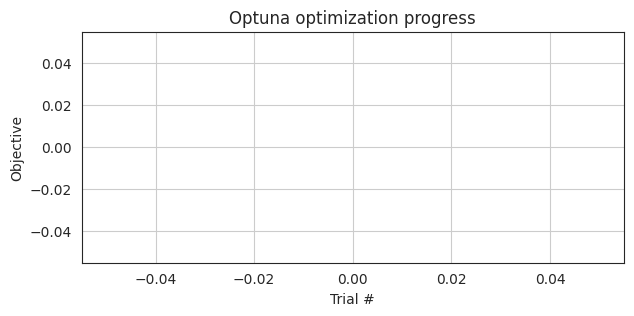

In [22]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

def cleanup_cb(study, trial):
    # Python‐side
    gc.collect()
    # CUDA‐side (no‐op on CPU only)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
study.optimize(
    objective,
    n_trials = 150,
    n_jobs   = 1,
    callbacks=[live_cb, cleanup_cb],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



[I 2025-08-21 12:23:29,804] A new study created in RDB with name: no-name-2ecc9c36-5eee-4a82-9bf3-2be6eb177bdb



▶ Trial 0 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.39480662875429895, 'DROPOUT_LONG': 0.47689186120617244, 'ATT_DROPOUT': 0.3798605864261398, 'INITIAL_LR': 5.1653875950654704e-05, 'ETA_MIN': 1.528986327586872e-06, 'WEIGHT_DECAY': 0.0005365173457392011, 'CLIPNORM': 0.382878777374451}

Full tensors Shapes:
  X         = torch.Size([2651598, 120, 15]) (samples, look_back, features)
  y         = torch.Size([2651598]) (samples,)
Split tensors Shapes:
  X_tr = torch.Size([1838271, 120, 15])
  X_val = torch.Size([400097, 120, 15])
  X_te = torch.Size([413230, 120, 15])
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1838271, val=400097, te=413230
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..782], total days=783
   te_day_id  ∈ [0..808], total days=809
4) instantiating DayWindowDatasets
   ds_tr days: 3808
   ds_val days: 783
   ds_te days: 809
5) building DataLoaders
   train_loader re

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
